# Question 3

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

learning_rate = 0.001
epoch_nums = 2
weight_decay = 5e-3
batch_size = 128
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225) 
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

### check cuda is avaiable

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### download data

In [3]:
train_transform = transforms.Compose(
    [transforms.RandomCrop((32, 32), padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(degrees=(0,180)),
     transforms.ToTensor(),
     transforms.Normalize(means, stds)])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### vizualize data

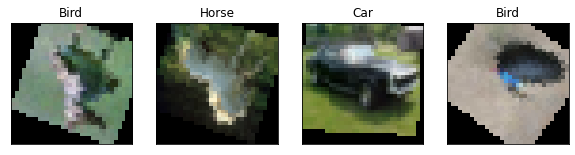

In [19]:
# vizualize data

train_data = trainset.data
train_data = train_data.reshape((train_data.shape[0], 1024 * 3))

def imshow(img):
    # unnormalized
    for i in range(3):
      img[i] = img[i] * stds[i] + means[i]  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



plt.figure(figsize=(10,5))
dataiter = iter(trainloader)
images, labels = dataiter.next()


for i in range(4):
  plt.subplot(2, 4, i+1)
  imshow(img=images[i])
  plt.xticks([])
  plt.yticks([])
  plt.title(classes[labels[i]])
plt.show()

### define CNN model


In [7]:
class CNN_Network(nn.Module):
  def __init__(self):
    super(CNN_Network, self).__init__()

    self.conv_layer = nn.Sequential(

        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.05),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.conv_layer(x)

    x = x.view(x.size(0), -1)

    return self.fc_layer(x)

### define loss function and optimizer

In [10]:
model = CNN_Network()
if train_on_gpu:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### train model

In [11]:
train_losslist = []
train_accuracylist = []

for epoch in range(epoch_nums):

  current_loss = 0.0
  current_accuracy = 0.0
  model.train()
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

    # zero the prarmeter gradients
    optimizer.zero_grad()

    # forward + backward + optimizer
    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    _, pred = torch.max(output, 1)
    current_accuracy += (torch.sum(torch.eq(pred, labels)).item())
    current_loss += loss.item() * inputs.size(0)

  train_acc = float(current_accuracy)/ len(trainloader.dataset)
  train_loss = float(current_loss) / len(trainloader.dataset)
  train_losslist.append(train_loss)
  train_accuracylist.append(train_acc)
  print(f'Epoch: {epoch + 1}  ====> \tTraining Loss: {train_loss} \tTraining Accuracy: {train_acc} ')    

print(' ----- Finished Training -----')

Epoch: 1  ====> 	Training Loss: 1.9542226824951172 	Training Accuracy: 0.24784 
Epoch: 2  ====> 	Training Loss: 1.7913587683868408 	Training Accuracy: 0.31576 
 ----- Finished Training -----


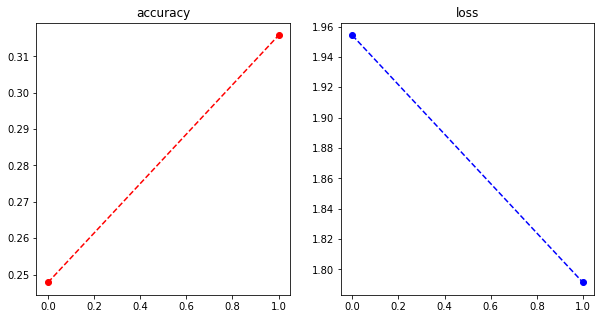

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_accuracylist, 'ro--')
plt.title('accuracy')

plt.subplot(1,2,2)
plt.plot(train_losslist, 'bo--')
plt.title('loss')

plt.show()

### test the model

In [18]:
correct_predict ={class_names: 0 for class_names in classes}
total_class ={class_names:0 for class_names in classes}


model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    _, prediction = torch.max(outputs, 1)

    for label, prediction in zip(prediction, labels):
      if label == prediction:
        correct_predict[classes[label]] += 1
      total_class[classes[label]]+=1
    
  for classname, correct_count in correct_predict.items():
    accuracy = 100 * float(correct_count) / total_class[classname]
    print("Accuracy for class {:s} is: {:.2f} % ({:d}, {:d})".
          format(classname, accuracy, correct_count, total_class[classname]))
  print('*'*100)
  total_correct = 0
  total_data = len(testloader.dataset)
  for k, v in correct_predict.items():
    total_correct += v
  print(f'Total Accuracy is :\t========>>\t{(total_correct/total_data) * 100}')

Accuracy for class Airplane is: 43.17 % (392, 908)
Accuracy for class Car is: 44.08 % (488, 1107)
Accuracy for class Bird is: 23.49 % (370, 1575)
Accuracy for class Cat is: 17.86 % (20, 112)
Accuracy for class Deer is: 35.49 % (307, 865)
Accuracy for class Dog is: 21.57 % (727, 3370)
Accuracy for class Frog is: 83.03 % (225, 271)
Accuracy for class Horse is: 37.30 % (163, 437)
Accuracy for class Ship is: 31.60 % (292, 924)
Accuracy for class Truck is: 36.66 % (158, 431)
****************************************************************************************************
Total Accuracy is :	========>>	31.419999999999998
